In [1]:
# Libraries
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
import joblib
from scipy import stats
import numpy as np
%matplotlib inline
import warnings

# Settings
sns.set_theme(style="darkgrid")
pd.set_option('display.max_rows', 10)

# Set up logging
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Import data and save it as DataFrame
data_df = pd.read_csv('/kaggle/input/human-cognitive-performance-analysis/human_cognitive_performance.csv')

# Dimensions of the data
print(f'The data contains {data_df.shape[0]} records and {data_df.shape[1]} columns.')

# Datatypes of the data
print(f'\nThe data contains the following data types: \n{data_df.dtypes.value_counts()}')

# Display driver data
data_df.head()

The data contains 80000 records and 13 columns.

The data contains the following data types: 
float64    5
object     4
int64      4
Name: count, dtype: int64


,User_ID,Age,Gender,Sleep_Duration,Stress_Level,Diet_Type,Daily_Screen_Time,Exercise_Frequency,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score,AI_Predicted_Score
0,U1,57,Female,6.5,3,Non-Vegetarian,6.5,Medium,41,583.33,65,36.71,39.77
1,U2,39,Female,7.6,9,Non-Vegetarian,10.8,High,214,368.24,58,54.35,57.68
2,U3,26,Male,8.2,6,Vegetarian,5.7,Low,429,445.21,49,32.57,29.54
3,U4,32,Male,7.8,9,Vegetarian,8.3,Low,464,286.33,94,70.15,74.59
4,U5,50,Male,9.7,2,Non-Vegetarian,11.3,Medium,365,237.65,62,87.54,91.78


In [3]:
# Drop data
data_copy = data_df.copy()
data_copy.drop(['User_ID', 'AI_Predicted_Score'], axis=1, inplace=True)

# Display driver data
data_copy.head()

,Age,Gender,Sleep_Duration,Stress_Level,Diet_Type,Daily_Screen_Time,Exercise_Frequency,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score
0,57,Female,6.5,3,Non-Vegetarian,6.5,Medium,41,583.33,65,36.71
1,39,Female,7.6,9,Non-Vegetarian,10.8,High,214,368.24,58,54.35
2,26,Male,8.2,6,Vegetarian,5.7,Low,429,445.21,49,32.57
3,32,Male,7.8,9,Vegetarian,8.3,Low,464,286.33,94,70.15
4,50,Male,9.7,2,Non-Vegetarian,11.3,Medium,365,237.65,62,87.54


In [4]:
# Missing data
data_copy.isnull().sum()

Age                   0
Gender                0
Sleep_Duration        0
Stress_Level          0
Diet_Type             0
                     ..
Exercise_Frequency    0
Caffeine_Intake       0
Reaction_Time         0
Memory_Test_Score     0
Cognitive_Score       0
Length: 11, dtype: int64

In [5]:
# Duplicate data
data_copy.duplicated().any().sum()

0

In [6]:
# Check data 
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   User_ID             80000 non-null  object 
 1   Age                 80000 non-null  int64  
 2   Gender              80000 non-null  object 
 3   Sleep_Duration      80000 non-null  float64
 4   Stress_Level        80000 non-null  int64  
 5   Diet_Type           80000 non-null  object 
 6   Daily_Screen_Time   80000 non-null  float64
 7   Exercise_Frequency  80000 non-null  object 
 8   Caffeine_Intake     80000 non-null  int64  
 9   Reaction_Time       80000 non-null  float64
 10  Memory_Test_Score   80000 non-null  int64  
 11  Cognitive_Score     80000 non-null  float64
 12  AI_Predicted_Score  80000 non-null  float64
dtypes: float64(5), int64(4), object(4)
memory usage: 7.9+ MB


In [7]:
# One-hot encode
data_copy = pd.get_dummies(data_copy, columns=['Gender', 'Diet_Type', 'Exercise_Frequency'])
data_copy.head()

,Age,Sleep_Duration,Stress_Level,Daily_Screen_Time,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score,Gender_Female,Gender_Male,Gender_Other,Diet_Type_Non-Vegetarian,Diet_Type_Vegan,Diet_Type_Vegetarian,Exercise_Frequency_High,Exercise_Frequency_Low,Exercise_Frequency_Medium
0,57,6.5,3,6.5,41,583.33,65,36.71,True,False,False,True,False,False,False,False,True
1,39,7.6,9,10.8,214,368.24,58,54.35,True,False,False,True,False,False,True,False,False
2,26,8.2,6,5.7,429,445.21,49,32.57,False,True,False,False,False,True,False,True,False
3,32,7.8,9,8.3,464,286.33,94,70.15,False,True,False,False,False,True,False,True,False
4,50,9.7,2,11.3,365,237.65,62,87.54,False,True,False,True,False,False,False,False,True


In [8]:
# Summary statistics
data_copy.describe()

,Age,Sleep_Duration,Stress_Level,Daily_Screen_Time,Caffeine_Intake,Reaction_Time,Memory_Test_Score,Cognitive_Score
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,38.525525,7.005333,5.493762,6.504646,248.988213,399.973579,69.498350,58.172395
std,12.101876,1.734435,2.865308,3.167072,144.541990,115.369329,17.305659,23.058522
min,18.000000,4.000000,1.000000,1.000000,0.000000,200.000000,40.000000,0.000000
25%,28.000000,5.500000,3.000000,3.800000,123.000000,300.150000,55.000000,40.910000
50%,39.000000,7.000000,5.000000,6.500000,249.000000,400.360000,70.000000,58.360000
75%,49.000000,8.500000,8.000000,9.200000,375.000000,499.250000,85.000000,75.830000
max,59.000000,10.000000,10.000000,12.000000,499.000000,599.990000,99.000000,100.000000


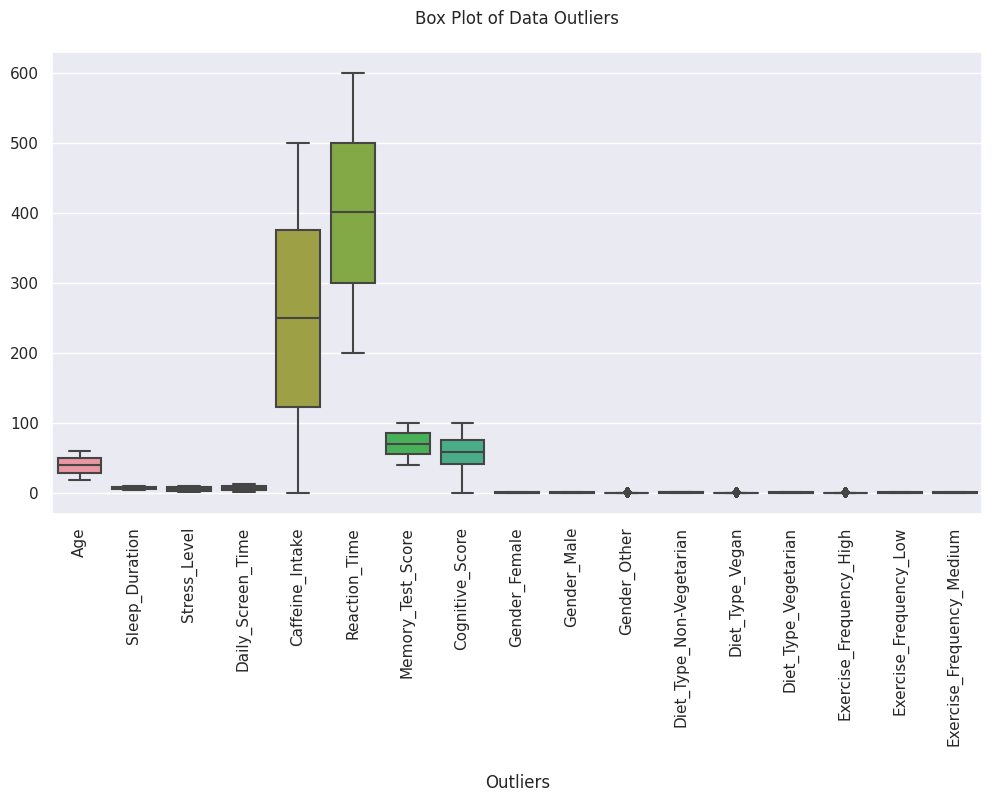

In [9]:
# Visualize with a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_copy)
plt.title('Box Plot of Data Outliers', pad=20)
plt.xticks(rotation=90)
plt.xlabel('Outliers', labelpad=20)
plt.show()

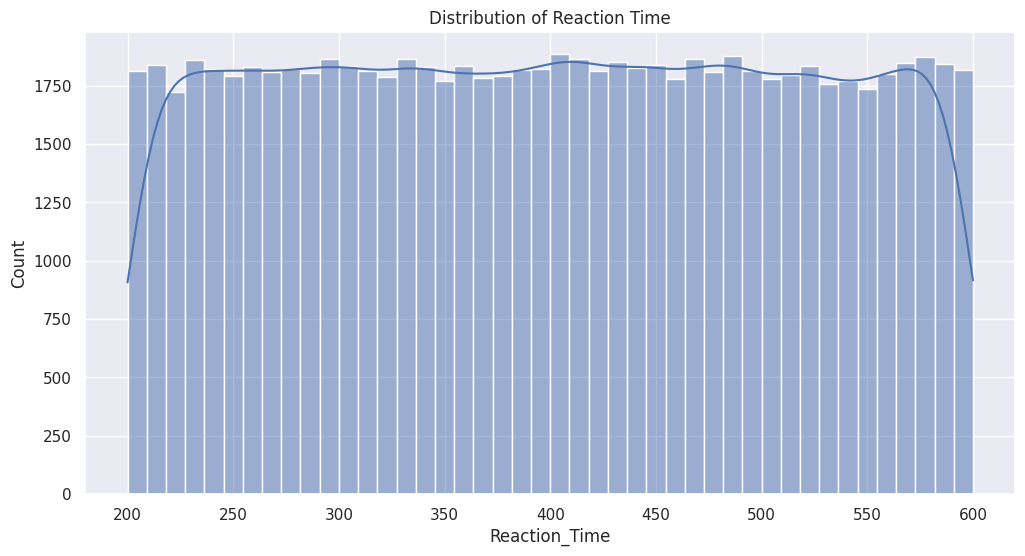

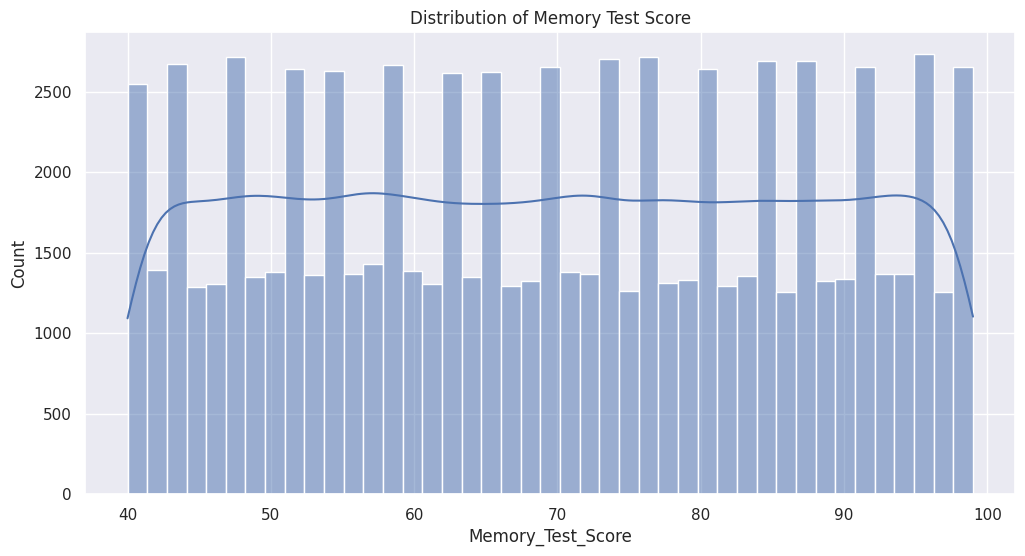

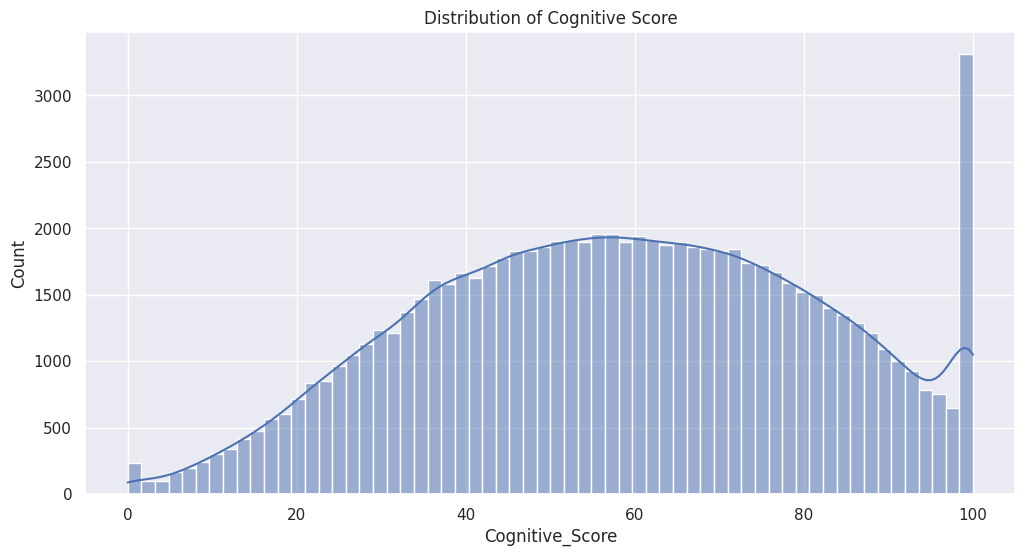

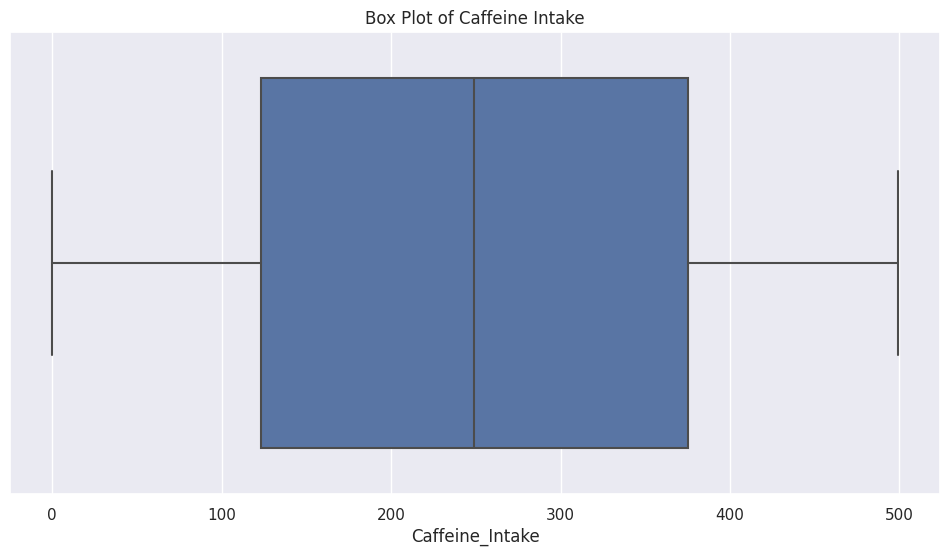

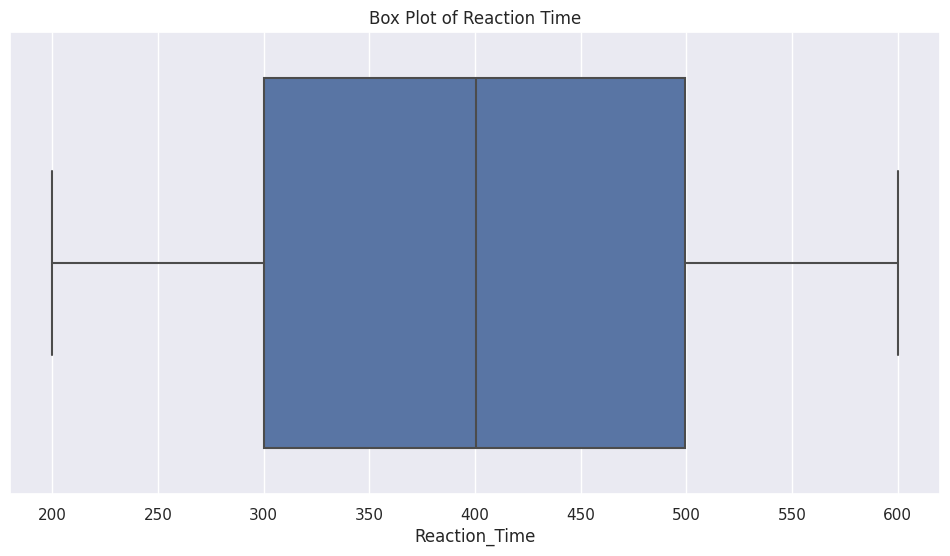

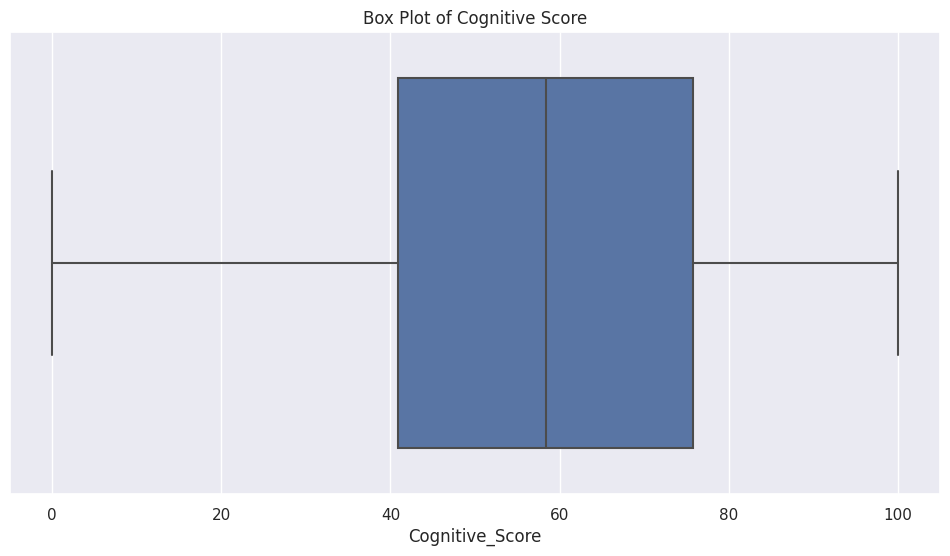

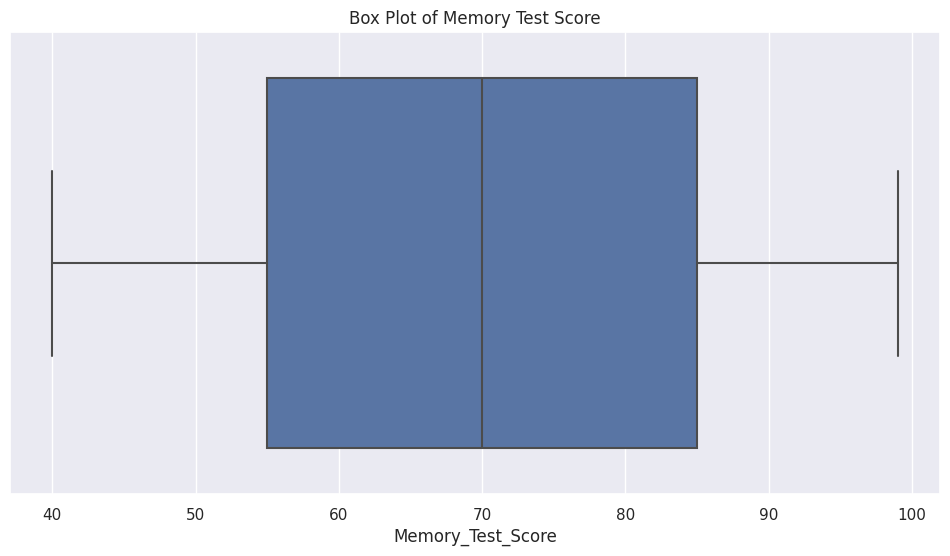

In [10]:
# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=data_copy, x="Reaction_Time", kde=True)
plt.title("Distribution of Reaction Time")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=data_copy, x="Memory_Test_Score", kde=True)
plt.title("Distribution of Memory Test Score")
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=data_copy, x="Cognitive_Score", kde=True)
plt.title("Distribution of Cognitive Score")
plt.show()

# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_copy, x="Caffeine_Intake")
plt.title("Box Plot of Caffeine Intake")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_copy, x="Reaction_Time")
plt.title("Box Plot of Reaction Time")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_copy, x="Cognitive_Score")
plt.title("Box Plot of Cognitive Score")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_copy, x="Memory_Test_Score")
plt.title("Box Plot of Memory Test Score")
plt.show()

<Figure size 1200x600 with 0 Axes>

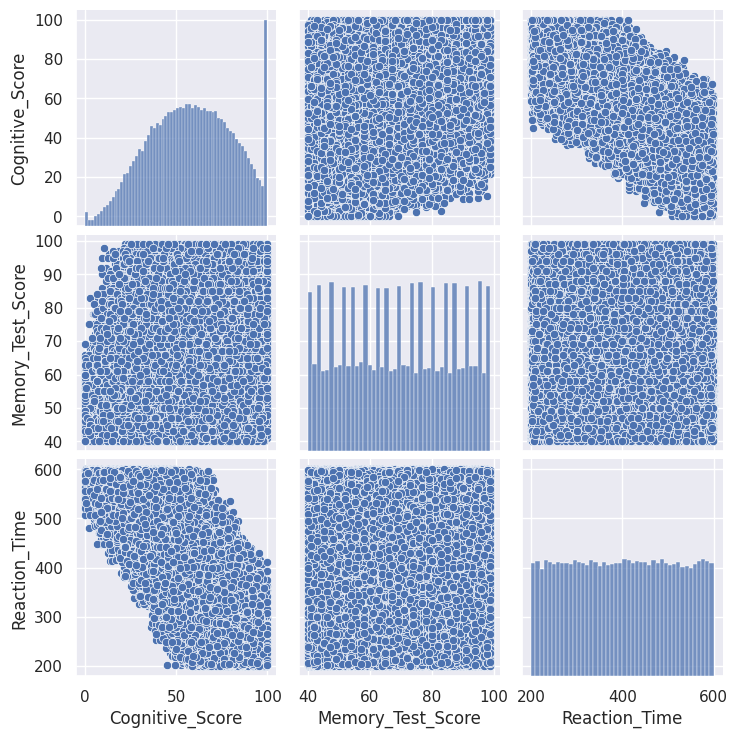

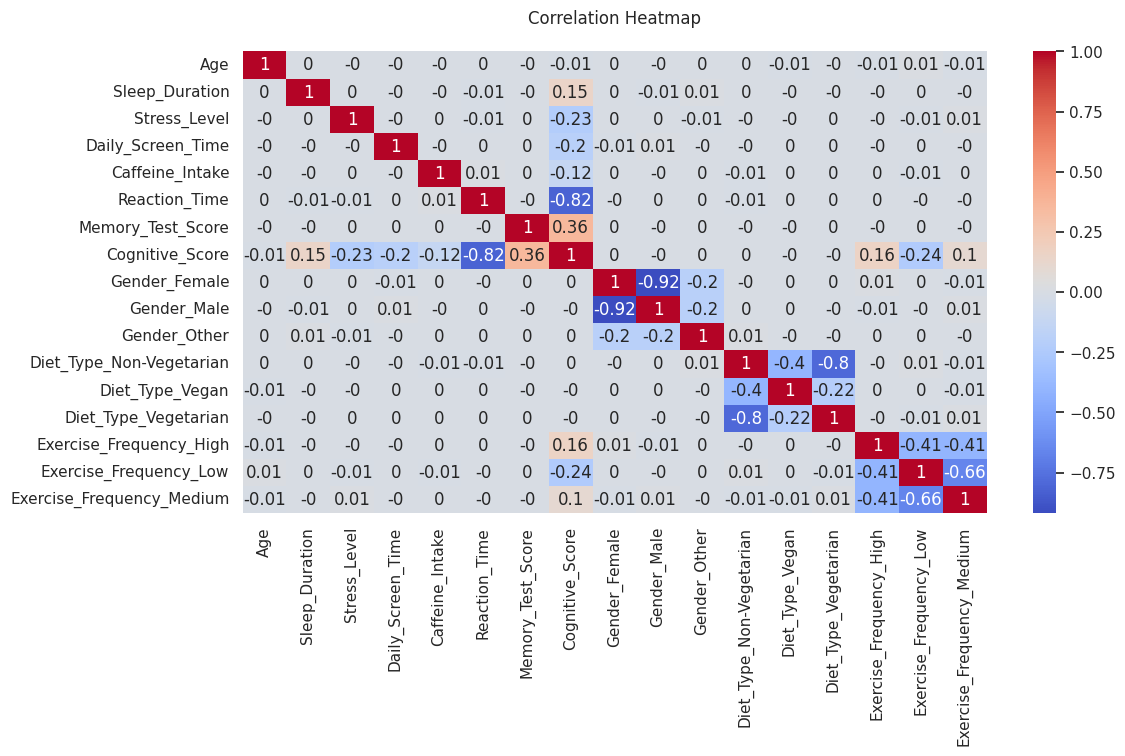

In [11]:
# Pairplot
plt.figure(figsize=(12, 6))
sns.pairplot(data_copy, vars=["Cognitive_Score", "Memory_Test_Score", "Reaction_Time"])
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 6))
corr = data_copy.corr().round(2)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap", pad=20)
plt.show()

In [12]:
# Separate majority and minority classes
df_majority = data_copy[data_copy['Cognitive_Score'] != 100]
df_minority = data_copy[data_copy['Cognitive_Score'] == 100]

# Downsample majority or upsample minority
df_majority_downsampled = resample(df_majority, 
                                  n_samples=len(df_minority)*3,
                                  random_state=42)

# Combine and shuffle
df_balanced = pd.concat([df_majority_downsampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42)

In [13]:
# Define model sets
X = df_balanced.drop('Cognitive_Score', axis=1)
y = df_balanced['Cognitive_Score']

# 先分割数据
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 然后仅对训练集进行标准化拟合
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 只在训练集上fit
X_test_scaled = scaler.transform(X_test)        # 测试集用训练集的scaler

assert X.shape[0] == y.shape[0], "X and y must have same number of samples"
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

X_train: (8860, 16), y_train: (8860,)


In [14]:
# Choose model 
model = LinearRegression()
model.fit(X_train_scaled, y_train)  # 使用标准化后的训练集

LinearRegression()

In [15]:
# Cross-validation
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)  # 使用标准化数据
print(f"Average CV Accuracy: {scores.mean():.2f}")

Average CV Accuracy: 0.99


In [16]:
# 使用标准化后的数据预测
y_train_pred = model.predict(X_train_scaled)  
y_pred = model.predict(X_test_scaled)        

In [17]:
# Check for overfitting
print(f"Train R²: {r2_score(y_train, y_train_pred):.3f}")
print(f"Test R²: {r2_score(y_test, y_pred):.3f}")

Train R²: 0.987
Test R²: 0.986


In [18]:
# Performance metrics
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")

R² Score: 0.986
MSE: 9.70
MAE: 2.13


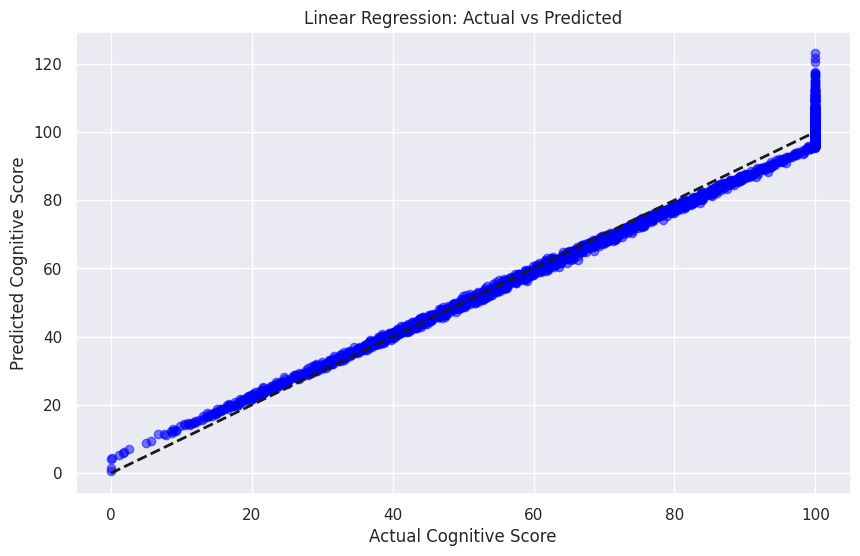

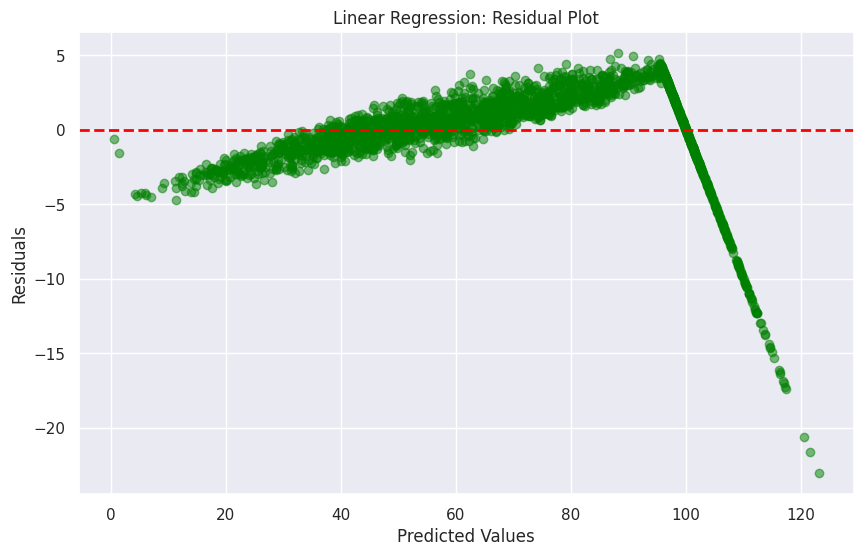

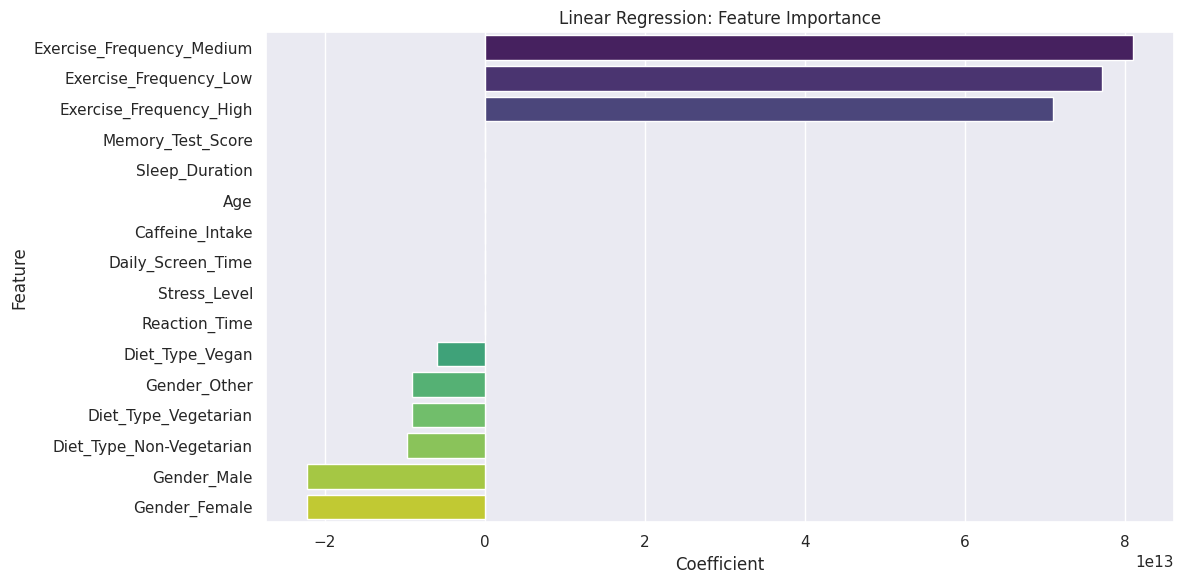

In [19]:
# ===== 插入的可视化代码 =====
# 1. 实际值 vs 预测值
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Cognitive Score')
plt.ylabel('Predicted Cognitive Score')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

# 2. 残差图
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linear Regression: Residual Plot')
plt.show()

# 3. 特征重要性
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title('Linear Regression: Feature Importance')
plt.tight_layout()
plt.show()


In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 初始化神经网络模型
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # 2层隐藏层，分别100和50个神经元
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True  # 防止过拟合
)

nn_model.fit(X_train_scaled, y_train)          # 训练使用标准化数据
y_pred_nn = nn_model.predict(X_test_scaled)    # 预测也使用标准化数据

# 评估神经网络
print("Neural Network Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_nn):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_nn):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_nn):.2f}")

print("\nLinear Regression vs Neural Network:")
print(f"Linear Regression R²: {r2_score(y_test, y_pred):.3f}")
print(f"Neural Network R²: {r2_score(y_test, y_pred_nn):.3f}")

Neural Network Performance:
R² Score: 0.998
MSE: 1.17
MAE: 0.72

Linear Regression vs Neural Network:
Linear Regression R²: 0.986
Neural Network R²: 0.998


  0%|          | 0/100 [00:00<?, ?it/s]

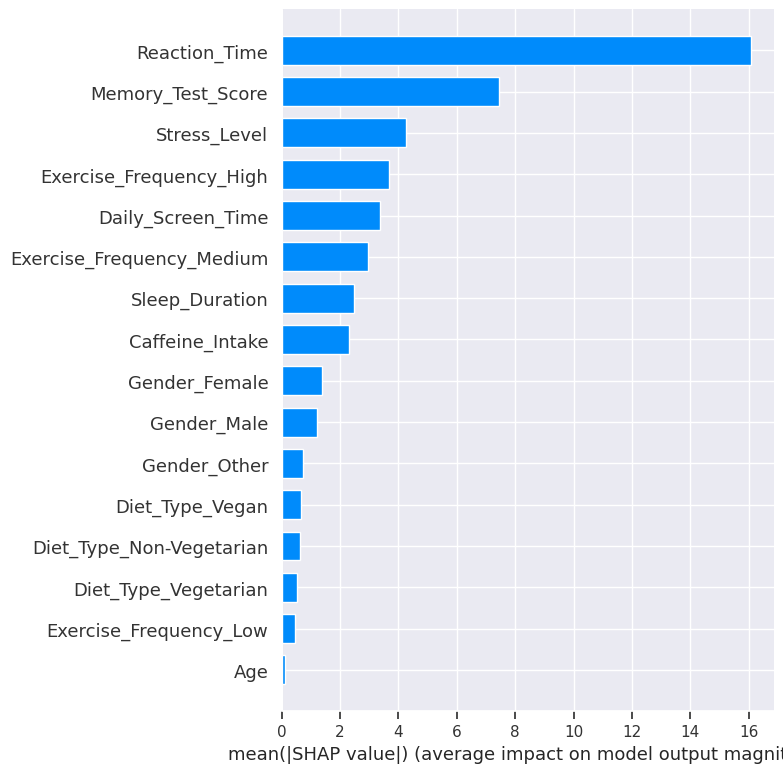

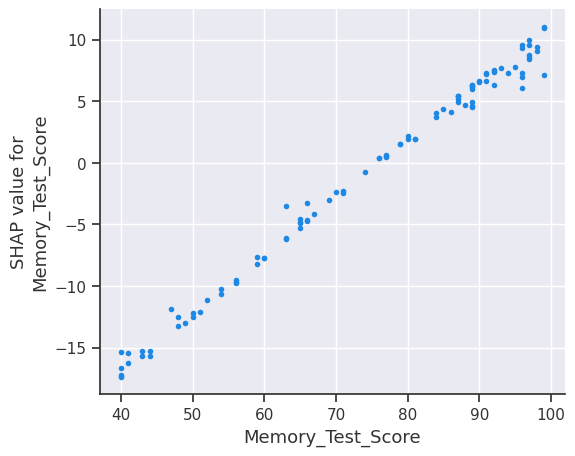

In [ ]:
import shap

explainer = shap.KernelExplainer(
    nn_model.predict, 
    X_train_scaled[:100]  # 使用标准化后的数据
)
shap_values = explainer.shap_values(X_test_scaled[:100])  
# 可视化单个预测的解释
shap.initjs()  # 初始化 JS 可视化（适用于 Jupyter Notebook）
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# 汇总图（全局特征重要性）
shap.summary_plot(shap_values, X_test[:100], plot_type="bar")

# 分析某个特征（如 'Memory_Test_Score'）的影响
shap.dependence_plot("Memory_Test_Score", shap_values, X_test[:100], interaction_index=None)

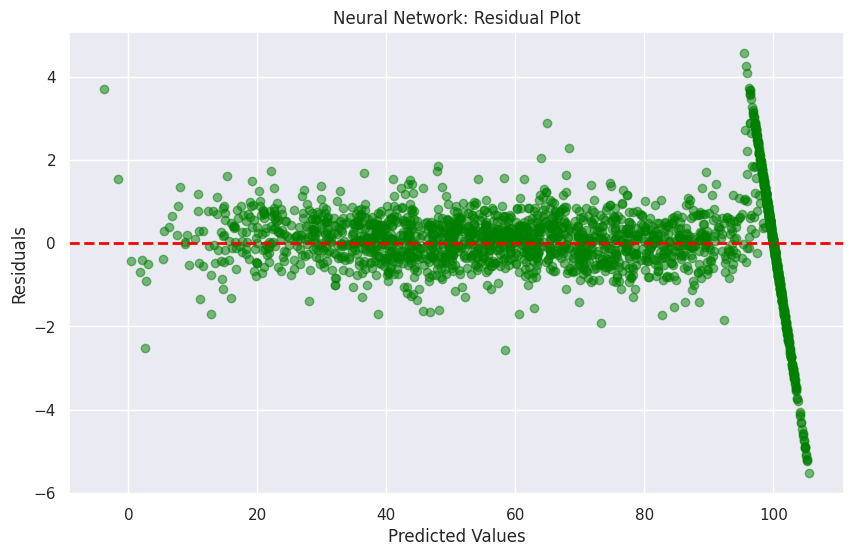

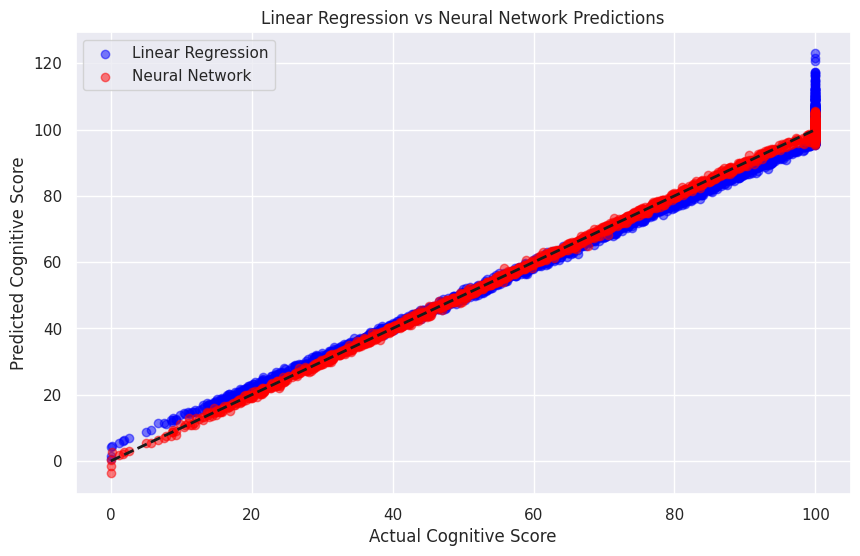

In [22]:
residuals = y_test - y_pred_nn
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_nn, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Neural Network: Residual Plot')
plt.show()

# 对比预测结果
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Linear Regression', color='blue')
plt.scatter(y_test, y_pred_nn, alpha=0.5, label='Neural Network', color='red')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Cognitive Score')
plt.ylabel('Predicted Cognitive Score')
plt.title('Linear Regression vs Neural Network Predictions')
plt.legend()
plt.show()

In [ ]:
joblib.dump(nn_model, 'cognitive_model2.pkl')  # 保存神经网络模型
joblib.dump(scaler, 'scaler.pkl')  

['scaler.pkl']

In [24]:
# 保存原始认知分数分布数据
original_data = pd.read_csv('/kaggle/input/human-cognitive-performance-analysis/human_cognitive_performance.csv')
original_scores = original_data['Cognitive_Score'].values

# 保存为 .npy 文件（更高效）
np.save('cognitive_score_distribution.npy', original_scores)